# Credit Card Data

## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Below is the command to download the data from the notebook:

```bash
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```

The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`).

## Preparation

- Download and read the dataset in pandas dataframe
- Create the target variable by mapping `yes` to 1 and `no` to 0
- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

Before implementing the above steps we need to import the required libraries:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Download the data (name the data credit_card.csv)
if not os.path.isfile('credit_card.csv'):
    !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv -O credit_card.csv

In [3]:
# Load the data
df = pd.read_csv('credit_card.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


Here's is the description of the columns:

- `card`: Categorical variable, **yes** if application for credit card accepted, **no** if not
- `reports`: Number of major derogatory reports
- `age`: Age n years plus twelfths of a year
- `income`: Yearly income (divided by 10,000)
- `share`: Ratio of monthly credit card
- `expenditure`: Average monthly credit card expenditure
- `owner`: **yes** if owns their home, **no** if rent
- `selfemp`: **yes** if self employed, **no** if not
- `dependents`: Number of dependents
- `months`: Months living at current address
- `majorcards`: Number of major credit cards held
- `active`: Number of active credit accounts

Let's find the number to total rows and columns and also the data types of these columns in the dataset.

In [4]:
# Check number of rows and columns
df.shape

(1319, 12)

In [5]:
# Check the data types
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

The target variable `card` is object type, we need to convert it into binary where yes is 1 and no is 0.

In [6]:
# Frequency distribution
df.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [7]:
# Convert 'card' column into binary
df.card = (df.card == 'yes').astype(int)

In [8]:
df.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

We can now split the data into 60% train, 20% validation, and 20% test sets.

In [9]:
from sklearn.model_selection import train_test_split

# Split the data (train full and test)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
# Split the data (train and validation)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Create target variable for train/val/test
y_train = df_train.card
y_val = df_val.card
y_test = df_test.card

# Remove target variable 'card' from train/val/test
del df_train['card']
del df_val['card']
del df_test['card']

In [10]:
# Check the split
len(df_train), len(df_val), len(df_test)

(791, 264, 264)

Seperate categorical and numerical columns and make list of each of them.

In [11]:
# Create lists of categorical and numerical columns
categorical = df_train.select_dtypes('object').columns.tolist()
numerical = df_train.select_dtypes('number').columns.tolist()

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that:

- For each numerical variable, use it as score and compute AUC with the `card` varaible
- Use the training dataset for that

If the AUC is < 0.5, invert this variable by putting "-" in front (e.g. `-df_trian['expenditure]`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [12]:
from sklearn.metrics import roc_auc_score

scores = []
for col in numerical:
    if col in ['reports', 'dependents', 'active', 'share']:
        score = roc_auc_score(y_train, df_train[col])
        scores.append((col, score.round(3)))

In [13]:
# Make dataframe from 'scores' list and sort the values in descening order
pd.DataFrame(scores, columns=['columns', 'scores']).sort_values(by='scores', ascending=False)

,columns,scores
1,share,0.989
3,active,0.604
2,dependents,0.467
0,reports,0.283


The column with highest AUC score is `share` which is `0.989`.

### Training the Model

Apply one-hot encoding with `DictVectorizer` and train the logistic regression with these parameter:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [14]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Instantial DictVectorizer
dv = DictVectorizer(sparse=False)

# Convert df_train to dictionary
train_dict = df_train.to_dict(orient='records')

# Fit and transform 'train_dict' to feature matrix
X_train = dv.fit_transform(train_dict)

# Create and train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [15]:
# Transform validation data to feature matrix
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# Calculate model prediction probabilites on validation data
y_pred = model.predict_proba(X_val)[:, 1]

# Calculate model AUC on y_val
roc_auc_score(y_val, y_pred).round(3)

0.995

The model AUC on validation data is `0.995`.

## Question 3

Now let's compute precision and recall for our model:

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.1
- 0.3
- 0.6
- 0.8

In [16]:
# List to store values of thresholds, tp, fp, fn, and tn
scores = []

# Array of 101 thresholds between 0 and 1 with step 0.01
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    # actual class labels
    actual_positive = y_val == 1
    actual_negative = y_val == 0
    
    # predicted class labels along different thresholds
    predict_positive = y_pred >= t
    predict_negative = y_pred < t
    
    # number of true positive and true negative
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    # number of false positive and false negative
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [17]:
# Convert scores list to dataframe
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,211,53,0,0
10,0.1,210,17,1,36
20,0.2,207,5,4,48
30,0.3,205,5,6,48
40,0.4,205,1,6,52
50,0.5,204,1,7,52
60,0.6,204,1,7,52
70,0.7,204,1,7,52
80,0.8,204,1,7,52
90,0.9,204,0,7,53


In [18]:
# Calculate and create columns for precision and recall
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores [::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,211,53,0,0,0.799242,1.000000
10,0.1,210,17,1,36,0.925110,0.995261
20,0.2,207,5,4,48,0.976415,0.981043
30,0.3,205,5,6,48,0.976190,0.971564
40,0.4,205,1,6,52,0.995146,0.971564
50,0.5,204,1,7,52,0.995122,0.966825
60,0.6,204,1,7,52,0.995122,0.966825
70,0.7,204,1,7,52,0.995122,0.966825
80,0.8,204,1,7,52,0.995122,0.966825
90,0.9,204,0,7,53,1.000000,0.966825


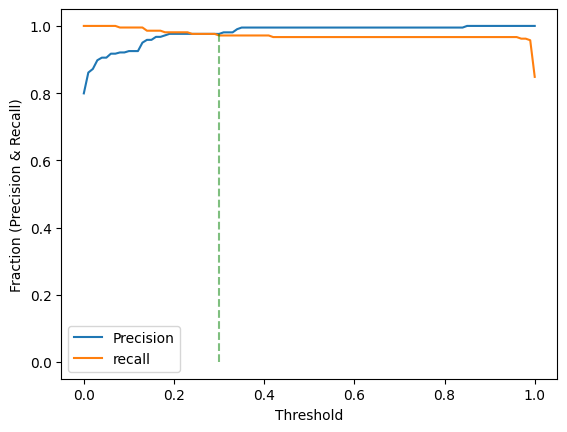

In [19]:
# Plot precision and recall scores along with different thresholds
plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.xlabel('Threshold')
plt.ylabel('Fraction (Precision & Recall)')
plt.vlines(0.3, 0, 0.98, color='green', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

The precision and recall curves intersect at `0.3` threshold.

## Question 4

Precision and reacll are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

This is the formula for computing F1:

$$\frac{2PrecisionRecall}{Precision+Recall}$$

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01.

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

In [20]:
# Calculate and create 'F1' column
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall,f1
0,0.0,211,53,0,0,0.799242,1.000000,0.888421
10,0.1,210,17,1,36,0.925110,0.995261,0.958904
20,0.2,207,5,4,48,0.976415,0.981043,0.978723
30,0.3,205,5,6,48,0.976190,0.971564,0.973872
40,0.4,205,1,6,52,0.995146,0.971564,0.983213
50,0.5,204,1,7,52,0.995122,0.966825,0.980769
60,0.6,204,1,7,52,0.995122,0.966825,0.980769
70,0.7,204,1,7,52,0.995122,0.966825,0.980769
80,0.8,204,1,7,52,0.995122,0.966825,0.980769
90,0.9,204,0,7,53,1.000000,0.966825,0.983133


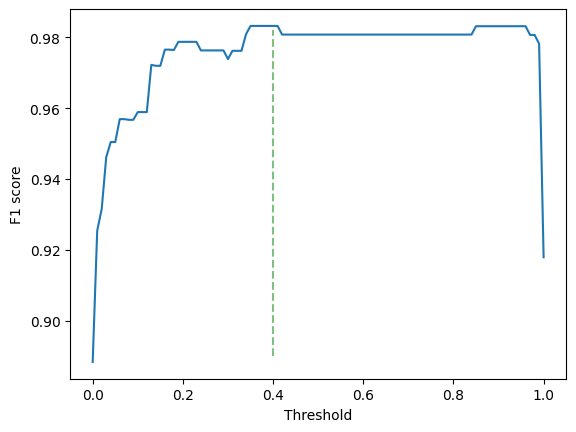

In [21]:
# Plot f1 scores along with different thresholds
plt.plot(df_scores.threshold, df_scores.f1)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.vlines(0.4, 0.89, 0.982, color='green', linestyle='--', alpha=0.5)

plt.show()

The maximal F1 score is at `0.4` threshold.

## Question 5

Use the `Kfold` class from Scikit-Learn to evaluate our model on 5 different folds:

```python
KFold(n_splits=5, shuffle=True, random_state=1)
```

- Iterate over different folds of `df_full_train`
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard deviation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

Let's create a function `train()` that will take three parameter as dataframe to convert into feature matrix, target variable, and regularizer for logistic regression and train the model.

In [22]:
def train(df_train, y_train, C=1.0):
    # Only include columns from 'categorical' and 'numerical' list
    # and convert dataframe to dict
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

Next, we'll create another function `predict()` for making predictions. This function will also have three parameter:

- `df`: dataframe for making prediction (validation or test)
- `dv`: DictVictorizer to convert dataframe to dictionary
- `model`: Trained model

In [23]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

Let's train the model using sklearn `KFold` for five iteration and calculate AUC on validation set.

In [24]:
from sklearn.model_selection import KFold

# Set kfold validation to 5
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# List to store AUC and Std scores
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    # extract train and validation data from 'df_full_train'
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    # Create target variables
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    # Train the model using 'df_train' with default (C=1.0) regularizer
    dv, model = train(df_train, y_train)
    
    # Make prediction on 'df_val'
    y_pred = predict(df_val, dv, model)
    
    # Calculate AUC on validation
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
print(f'AUC: {np.mean(scores):.3f}, Std: +-{np.std(scores):.3f}')

AUC: 0.996, Std: +-0.003


The largest standard deviation of the AUC scores across different folds is `0.003`.

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C:

- Iterate over the following C values: `[0.01, 0.1, 1, 10]`
- Initialize `KFold` with the same parameters as previously
- Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- Compute the mean score as well as std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [25]:
from tqdm.auto import tqdm

# Create a list to store 'C', 'auc_mean', 'auc_std'
best_scores = []

# List of hyperparameter
hyper_list = [0.01, 0.1, 1, 10]

for c in tqdm(hyper_list):
    # Set kfold validation to 5
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # List to store AUC and Std scores
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        # extract train and validation data from 'df_full_train'
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        # Create target variables
        y_train = df_train.card.values
        y_val = df_val.card.values

        # Train the model using 'df_train' with each regularizer in 'hyper_list'
        dv, model = train(df_train, y_train, C=c)

        # Make prediction on 'df_val'
        y_pred = predict(df_val, dv, model)

        # Calculate AUC on validation
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    best_scores.append((c, np.mean(scores).round(3), np.std(scores).round(3)))

  0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
best_scores_df = pd.DataFrame(best_scores, columns=['regularizer', 'auc_mean', 'auc_std'])
best_scores_df

,regularizer,auc_mean,auc_std
0,0.01,0.992,0.006
1,0.10,0.995,0.004
2,1.00,0.996,0.003
3,10.00,0.996,0.003


Find the best mean score where the std is lowest and regularizer (C) is smallest.

In [27]:
# Sort the values of 'auc_mean' in descending order, and
# for 'auc_std' and 'regularizer' in ascending order
best_scores_df.sort_values(by=['auc_mean', 'regularizer', 'auc_std'],
                           ascending=[False, True, True])

,regularizer,auc_mean,auc_std
2,1.00,0.996,0.003
3,10.00,0.996,0.003
1,0.10,0.995,0.004
0,0.01,0.992,0.006


So it is the value of `C=1` when the AUC mean is highest and Std has the lowest value.